In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

image_size = 28 # width and length
no_of_different_labels = 10 #  i.e. 0, 1, 2, 3, ..., 9
image_pixels = image_size * image_size
data_path = "data/mnist/"
train_data = np.loadtxt(data_path + "mnist_train.csv", 
                        delimiter=",")
test_data = np.loadtxt(data_path + "mnist_test.csv", 
                       delimiter=",") 
test_data[:10]

array([[7., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [9., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.]])

In [277]:
A = train_data[2:5,1:]
A = A.T
B = np.reshape(A,(28,28,3))

In [745]:
class UOM(object):
    #A SOM without 2D structure
    #much faster
    #nnodes: number of neurons
    #alpha: renew rates
    def __init__(self,indata,alpha):
        self.indata = indata
        self.alpha = alpha
        
    def mxinit(self,nnodes,init='sample'):
        #sample: choose random sample from indata
        #tabula_rasa: random value    
        self.nnodes = nnodes
        if init == 'sample':
            index = np.random.randint(len(self.indata),size=nnodes)
            self.matrix = self.indata[index]
        elif init == 'tabula_rasa':
            self.matrix = np.random.rand(nnodes,np.shape(self.indata)[1])
        self.matrix = self.normalize(self.matrix)
        return self.matrix
    
    def find_bmu(self,data):
        f_rate = np.dot(data,self.matrix.T)
        bmu = np.argmax(f_rate,axis=1)
        return bmu,f_rate
    
    def train(self,data,r_mode,treshold):
        #update bmu in matrix with according sample
        data = self.normalize(data)
        bmu = self.find_bmu(data)
        self.renew(bmu,data,r_mode,treshold)
        #np.dot(data.T,np.max(bmu[1],axis=1)).T
        self.matrix = self.normalize(self.matrix)
        return self.matrix
    
    def train_we(self,data,we_tr,r_mode,treshold):
        #replace inactive elements with new ones
        #we_tr: repalcement threshold for activation 
        data = self.normalize(data)
        bmu = self.find_bmu(data)
        self.renew(bmu,data,r_mode,treshold)
        hitmap = np.bincount(bmu[0])
        remain_list = np.argwhere(hitmap>we_tr)
        add_size = self.nnodes-len(remain_list)
        index = np.random.randint(len(self.indata),size=add_size)
        add_matrix = self.indata[index]
        self.matrix = self.matrix[remain_list][:,0,:]
        self.matrix = np.concatenate((self.matrix,add_matrix),axis=0)
        self.matrix = self.normalize(self.matrix)
        return self.matrix
    
    def renew(self,bmu,data,r_mode='none',treshold=0):
        #rate mode: learning rate of a unit depends on active rate
        #treshold mode: those weak activities will not be learned
        if r_mode=='none':
            self.matrix[bmu[0]] = self.matrix[bmu[0]]+self.alpha*data
        elif r_mode=='rate':
            a_rate = np.max(self.normalize(bmu[1]),axis=1)
            self.matrix[bmu[0]] = self.matrix[bmu[0]]+self.alpha*(data.T*a_rate).T
        elif r_mode=='treshold':
            a_rate = np.max(self.normalize(bmu[1]),axis=1)
            a_rate[(a_rate<treshold)]=0
            a_rate[(a_rate>=treshold)]=1
            self.matrix[bmu[0]] = self.matrix[bmu[0]]+self.alpha*(data.T*a_rate).T
        return self.matrix     
    
    def loop_train(self,train_data,loops,re_elect=False,we_tr=0.1,r_mode='none',treshold=0):
        #renew in batches
        #re_elect: to replace inactive nodes
        stl = len(train_data)//loops
        if re_elect==True:
            for i in range(loops):
                self.train_we(train_data[i*stl:(i+1)*stl],we_tr,r_mode,treshold)
        elif re_elect==False:
            for i in range(loops):
                self.train(train_data[i*stl:(i+1)*stl],r_mode,treshold)
        return self.matrix 
        
    def normalize(self,weights,mean=1,bias=0):
        newweights = (weights.T/np.sum(weights,axis=1)).T *(np.shape(weights)[1])*mean -bias
        return newweights

In [757]:
M = UOM(train_data[:1000,1:],0.5)
M.mxinit(40)
G = M.loop_train(train_data[1000:10000,1:],20,re_elect=True,r_mode='rate',treshold=0.1)

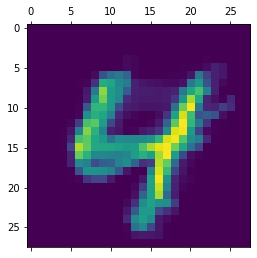

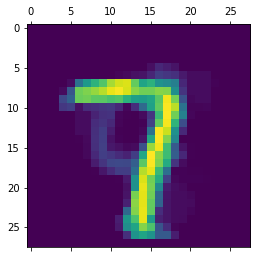

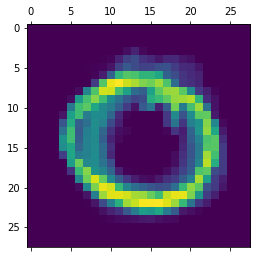

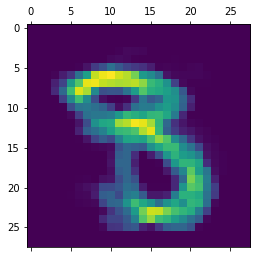

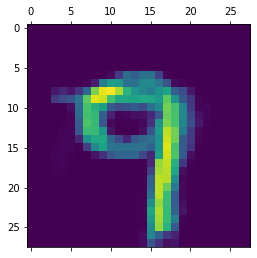

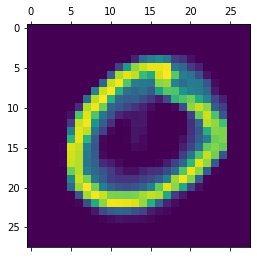

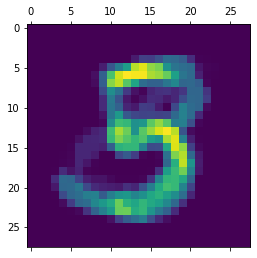

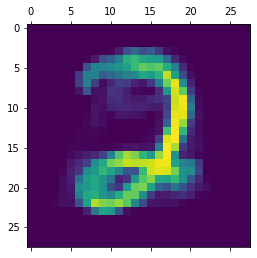

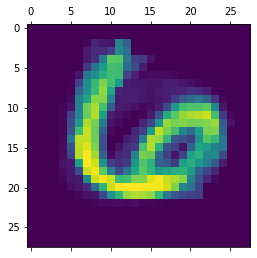

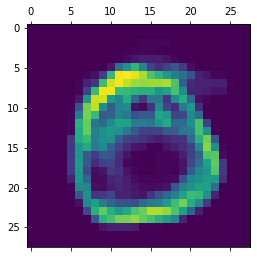

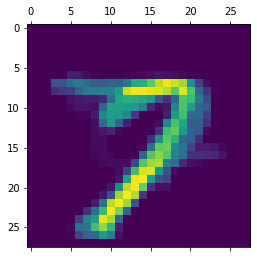

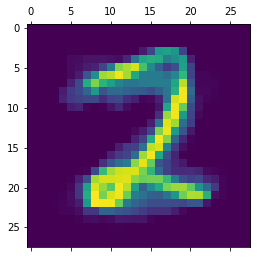

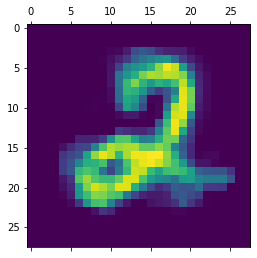

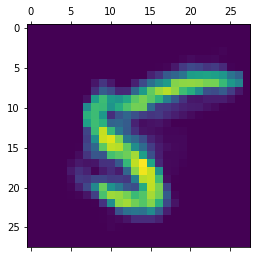

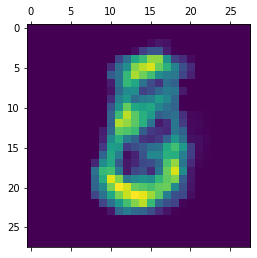

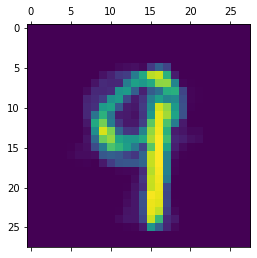

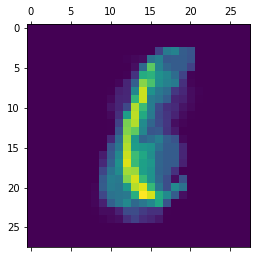

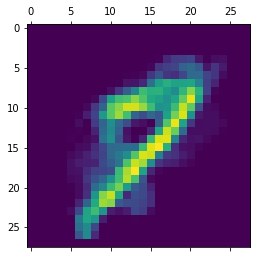

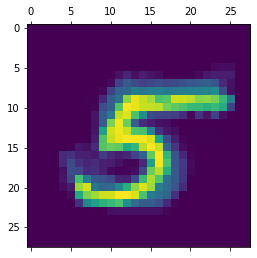

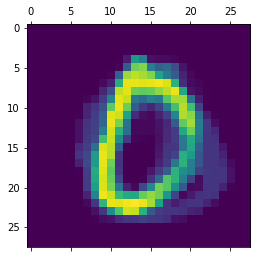

In [755]:
for i in range(20):
    plt.matshow(np.reshape(G[i],(28,28)))

In [456]:
class dreamNN(object):
    def __init__(self,UOM,uom_data,nnodes,nol,alpha,acc_rate):
        #nol: number of labels, how many kinds of different labels do u have
        #nnodes: number of nodes in matrix
        #acc_rate: treshold of WHAT IS A GOOD NODE
        self.UOM = UOM
        self.nol = nol
        self.nnodes = nnodes
        self.alpha = alpha
        self.acc_rate = acc_rate
        
        self.M = self.UOM(uom_data[:500],self.alpha)
        self.M.mxinit(nnodes)
        self.M.loop_train(uom_data[500:],10,'true')
        
    def dream_loop(self,train_data,loops):
        itv = len(train_data)//loops
        for i in range(loops):
            new_data = self.test_remain(train_data[(i*itv):((i+1)*itv)])
            self.M.loop_train(new_data[:,1:],3,'true')
        return self.M.matrix
        

    def lblist(self,data):
        #for traindata, make a bmu/label list by SOM
        #bmumatrix: fire rate for every label every node in SOM
        #bmusamples: firing index in traindata for every SOM node
        label=data[:,0]
        bmumatrix = np.zeros((self.nol,self.nnodes))
        bmulist = self.M.find_bmu(data[:,1:])
        for i in range(self.nnodes):
            bmusamples = np.argwhere(bmulist[0]==i)
            for j in bmusamples:
                bmumatrix[np.intc(label[j]),i]+=1 
        return bmumatrix
    
    def som_remain(self,bmumatrix):
        #choose "useful" part from SOM matrix
        #total_f: fires rate for each matrix node
        #max_f: fire rate for most fired label 
        total_f = sum(bmumatrix)
        max_f = np.max(bmumatrix,axis=0)
        acc_rate = max_f/(total_f+1)
        #for each non-zero-hit unit, percentage of fire with one label
        good_p = np.argwhere(acc_rate>self.acc_rate)
        return good_p
    
    def test_remain(self,test_data):
        #choose data that do not fire 
        good_p = self.som_remain(self.lblist(test_data))
        test_bmu = self.M.find_bmu(test_data[:,1:])[0]
        h_test_index = np.isin(test_bmu,good_p)
        h_testdata = test_data[(h_test_index==0)]
        print(len(h_testdata))
        return h_testdata

    def data2lb(self,check_data):
        bmu = np.intc(self.M.find_bmu(check_data)[0])
        #print(bmu)
        labels = self.ind[bmu]
        return labels
    
    def check(self):
        labels = self.testdata[:,0]
        p_labels = self.data2lb(self.testdata[:,1:])
        dv = (labels-p_labels)
        #print(dv)
        rc_sample = self.testdata[np.argwhere(dv!=0)]
        self.rc_sample = rc_sample[:,0,:]
        return self.rc_sample
    
    def sleep(self):
        som_remain = self.M.matrix[np.argwhere(D[0,:]==-1)]
        som_remain = som_remain[:,0,:]
        sp_next = np.concatenate((self.rc_sample[:,1:],som_remain))
        return sp_next


In [464]:
T = dreamNN(UOM,train_data[:5000,1:],30,10,0.5,0.8)
G = T.dream_loop(train_data[5000:40000],40)

720
696
739
681
677
646
729
780
822
709
793
779
790
711
767
793
685
750
690
756
787
748
852
698
767
798
736
752
787
769
812
842
786
723
739
859
844
725
681
806


In [9]:
T = dreamNN(UOM,train_data[:10000],test_data,1000,10,0.3,0.8)
T.train_UOM(train_data[:10000,1:],train_data[10000:20000,1:])
for i in range(40):
    lm = T.lblist()
    G = T.som_remain(lm)
    H = T.test_remain(train_data[(i*1000):((i+1)*1000),1:])
    new_data = H
    T.M.train(new_data)

544
466
425
386
372
343
298
339
283
254
251
237
212
209
180
173
156
177
154
172
153
149
178
162
144
144
117
135
121
103
129
139
130
138
118
123
128
154
114
122


In [31]:
A = np.asarray([[1,2,3],[4,5,6]])
B = np.asarray([5,6])
A.T*B

array([[ 5, 24],
       [10, 30],
       [15, 36]])

In [383]:
class convolution(object):
    #cut vision into squares
    def __init__(self,csize,radius,stride=1,padding=True,channel=1):
        #csize: original size [x,y]
        #radius: radius of kernel
        self.csize=csize
        self.radius=radius
        self.diameter=radius*2+1
        self.stride=stride
        self.padding=padding
        self.channel=channel
        self.cv_index()
    

    def pd(self,data,margin=-1,pdvalue=0):
        #1D to 2D, padding, 2D to 1D
        #margin: padding margin, default=radius
        if margin==-1:
            margin=self.radius
        #reshape data to csize square
        sqdata=np.reshape(data,(len(data),self.csize[0],self.csize[1]))
        pdsqdata=np.pad(sqdata,margin,'constant',constant_values=pdvalue)[margin:-margin]
        pddata=np.reshape(pdsqdata,(len(data),(self.csize[0]+2*margin)*(self.csize[1]+2*margin)))
        return pddata
        
    def cv_index(self):
        #return index of tiles in 1D
        if self.padding!=True:
            self.csize[0]=self.csize[0]-2*self.radius
            self.csize[1]=self.csize[1]-2*self.radius
            #if no padding, size should -2*radius
        self.index=[]
        for i in range(self.csize[0]):
            for j in range(self.csize[1]):
                localindex = []
                for m in range(self.diameter):
                    for n in range(self.diameter):
                        d_index = [(i+m)*(self.csize[1]+self.radius*2)+j+n]
                        localindex.append(d_index)
                if i%self.stride==0 and j%self.stride==0:
                    self.index.append(localindex)
        return self.index
    
    def to_tiles(self,data):
        #output all tiles as 1D array, for training or forwarding
        if self.padding==True:
            pddata=self.pd(data)
        else:
            pddata=data
        self.tiles = pddata[:,self.index][:,:,:,0]
        if self.channel>1:
            self.tiles=np.reshape(self.tiles,(np.shape(self.tiles)[0],np.shape(self.tiles)[1],np.shape(self.tiles)[2]*np.shape(self.tiles)[3]))
            #if multichannel, output combine channels
        return self.tiles
    
    def norm(self,data):
        #normalization for batch of 1D tiles
        mean = np.mean(data,axis=1)
        if self.channel==1:
            nordata = data/(np.tile(mean,(self.diameter**2,1)).T)
        elif self.channel>1:
            nordata = data/(np.tile(mean,(self.channel*self.diameter**2,1)).T)
        return nordata
    
    def wt_tiles(self,data,tres=0.1,normalize=True):
        #generate 'well-temperated' tiles, a.k.a. beyond treshold, and normalized tiles, for training
        self.to_tiles(data)
        all_tiles = np.reshape(self.tiles,(np.shape(self.tiles)[0]*np.shape(self.tiles)[1],np.shape(self.tiles)[2]))
        av_index = np.argwhere(np.sum(all_tiles,axis=1)>tres)
        nice_tiles = all_tiles[av_index][:,0,:]
        if normalize==True:
            nice_tiles=self.norm(nice_tiles)
        return nice_tiles
    
    def to_forward(self,data,UOM):
        #forward for multi-channel matrix
        forward=[]
        t_data = self.to_tiles(data)
        for i in t_data:
            cl_forward = UOM.find_bmu(i)[1]
            forward.append(cl_forward)
        forward=np.asarray(forward)
        return forward

class pooling(object):
    def __init__(self,csize,diameter,stride=1,mode='max'):
        self.csize=csize
        self.diameter=diameter
        self.stride=stride
        self.mode=mode
        self.pl_index()
        
    def pl_index(self):
        self.index=[]
        for i in range(self.csize[0]-self.diameter+1):
            for j in range(self.csize[1]-self.diameter+1):
                localindex = []
                for m in range(self.diameter):
                    for n in range(self.diameter):
                        d_index = [(i+m)*(self.csize[1])+j+n]
                        localindex.append(d_index)
                if i%self.stride==0 and j%self.stride==0:
                    self.index.append(localindex)
        return self.index
    
    def to_pooling(self,data):
        tiles = data[:,self.index]
        tiles = tiles[:,:,:,0]
        if self.mode=='max':
            pooled = np.max(tiles,axis=2)
        elif self.mode=='average':
            pooled = np.mean(tiles,axis=2)
        elif self.mode=='hnh':
            pooled = (np.max(tiles,axis=2)+np.mean(tiles,axis=2))/2
        elif self.mode=='free':
            pooled = self.free_pooling(data)
        return pooled
    
#    def free_pooling(self,data):

class LGN(object):
    #some basics,like on/off-center, colors2grey, etc...
    def __init__(self,data,csize,channel='mono'):
        self.csize=csize
        if channel=='mono':
            self.sqdata=np.reshape(data,(len(data),csize,csize))
        if channel=='RGB':
            grey_data=np.mean(data,axis=2)
            self.sqdata=np.reshape(grey_data,(len(data),csize,csize))
            self.c_sqdata=np.reshape(data,(len(data),csize,csize,3))
    
    def oocenter(self,tres=0):
        dfdata = 4*self.sqdata[:,1:-1,1:-1]-self.sqdata[:,:-2,:-2]-self.sqdata[:,2:,2:]-self.sqdata[:,:-2,2:]-self.sqdata[:,2:,:-2]
        on_center=dfdata+0
        off_center=dfdata+0
        on_center[on_center<tres]=0
        off_center[off_center>(-tres)]=0
        plt.matshow(-on_center[3])
        return on_center,-off_center

        
        

In [744]:
C2=convolution([28,28],2)
C2.cv_index()

[[[0],
  [1],
  [2],
  [3],
  [4],
  [32],
  [33],
  [34],
  [35],
  [36],
  [64],
  [65],
  [66],
  [67],
  [68],
  [96],
  [97],
  [98],
  [99],
  [100],
  [128],
  [129],
  [130],
  [131],
  [132]],
 [[1],
  [2],
  [3],
  [4],
  [5],
  [33],
  [34],
  [35],
  [36],
  [37],
  [65],
  [66],
  [67],
  [68],
  [69],
  [97],
  [98],
  [99],
  [100],
  [101],
  [129],
  [130],
  [131],
  [132],
  [133]],
 [[2],
  [3],
  [4],
  [5],
  [6],
  [34],
  [35],
  [36],
  [37],
  [38],
  [66],
  [67],
  [68],
  [69],
  [70],
  [98],
  [99],
  [100],
  [101],
  [102],
  [130],
  [131],
  [132],
  [133],
  [134]],
 [[3],
  [4],
  [5],
  [6],
  [7],
  [35],
  [36],
  [37],
  [38],
  [39],
  [67],
  [68],
  [69],
  [70],
  [71],
  [99],
  [100],
  [101],
  [102],
  [103],
  [131],
  [132],
  [133],
  [134],
  [135]],
 [[4],
  [5],
  [6],
  [7],
  [8],
  [36],
  [37],
  [38],
  [39],
  [40],
  [68],
  [69],
  [70],
  [71],
  [72],
  [100],
  [101],
  [102],
  [103],
  [104],
  [132],
  [133],
  [134],

In [387]:
in_dataX=train_data[:400,1:]
LGN(in_dataX,28)


[[[0], [1], [2], [5], [6], [7], [10], [11], [12]],
 [[2], [3], [4], [7], [8], [9], [12], [13], [14]],
 [[10], [11], [12], [15], [16], [17], [20], [21], [22]],
 [[12], [13], [14], [17], [18], [19], [22], [23], [24]]]

In [392]:
in_data2 = train_data[:4000,1:]

C2=convolution([28,28],2)
tr_data2 = C2.wt_tiles(in_data2,tres=800)
print(np.shape(tr_data2))

M2=UOM(tr_data2[:1000],40,0.1)
M2.mxinit()
M2.loop_train(tr_data2[1001:],10,r_mode='treshold',treshold=0.3)

out_d2=C2.to_forward(in_data2,M2)

P2 = pooling([28,28],4,4)
p_out_d2=P2.to_pooling(out_d2)

print(np.shape(p_out_d2))

in_data3 = p_out_d2

C3=convolution([7,7],1,padding=False,channel=40)
tr_data3 = C3.wt_tiles(in_data3,tres=800)
print(np.shape(tr_data3))

M3=UOM(tr_data3[:1000],20,0.1)
M3.mxinit()
M3.loop_train(tr_data3[1001:],10,r_mode='treshold',treshold=0.3)

out_d3=C3.to_forward(in_data3,M3)
print(np.shape(out_d3))

P3 = pooling([5,5],3,2)
p_out_d3=P3.to_pooling(out_d3)
print(np.shape(p_out_d3))


(955859, 25)
(4000, 49, 40)
(99943, 360)
(4000, 25, 20)
(4000, 4, 20)


In [362]:
print(np.shape(p_out_d2))

(400, 49, 40)


In [741]:
class CKNN(object):
    def __init__(self,UOM,nol):
        self.UOM=UOM
        self.nol=nol
        
    def label_sp(self,data):
        #seprate data accoding to labels
        labels = data[:,0]
        lb_data=[]
        for i in range(self.nol):
            index = np.argwhere(labels==i)
            lb_data.append(data[index][:,0,:])
        return lb_data
    
    def build_UOM(self,nnodes,train_data,alpha):
        #initiate UOM matrix for given data
        M = UOM(train_data[:500,1:],0.1)
        M.mxinit(nnodes)
        M.loop_train(train_data[500:1,1:],10,r_mode='treshold',treshold=0.3)
        return M
        
    def label_UOM(self,nnodes,data,alpha):
        #build a UOM matrix list for each label
        lb_data=self.label_sp(data)
        self.UOMs=[]
        for i in range(self.nol):
            U2i=self.build_UOM(nnodes,lb_data[i],alpha)
            self.UOMs.append(U2i)
        return self.UOMs
    
    def united_UOM(self):
        #self.label_UOM(nnodes,data,alpha)
        #output a united matrix and its index
        self.UOMindex = np.zeros(self.UOMs[0].nnodes)
        self.u_UOM = self.UOMs[0].matrix
        for i in range(self.nol-1):
            num_lb=self.UOMs[i+1].nnodes
            lb_list=np.ones(num_lb)
            self.u_UOM=np.concatenate((self.u_UOM,self.UOMs[i+1].matrix))
            self.UOMindex=np.concatenate((self.UOMindex,lb_list*(i+1))) 
        return self.u_UOM,self.UOMindex
            
    def g_bmu(self,matrix,data):
        #get bmu with united matrix
        matrix = self.normalize(matrix)
        data = self.normalize(data)
        f_rate = np.dot(data,matrix.T)
        bmu = np.argmax(f_rate,axis=1)
        return bmu,f_rate
    
    def d_list(self,data):
        #index of bmu_label!=label
        bmulist = self.g_bmu(self.u_UOM,data[:,1:])[0]
        dindex = np.argwhere(self.UOMindex[bmulist]!=data[:,0])
        print(len(dindex))
        return dindex
    
    def odd_train(self,data,loops=4):
        t_data = data[self.d_list(data)][:,0,:]
        self.lb_train(t_data,loops)
        self.united_UOM()
        return self.u_UOM
        
    def lb_train(self,data,loops):
        lb = data[:,0]
        r_data = data[:,1:]
        for i in range(self.nol):
            index = np.argwhere(lb==i)
            self.UOMs[i].loop_train(r_data[index][:,0,:],loops)
        return self.UOMs
    
    def renew_add(self,data):
        #mis-classified training-data will be added to UOM matrix
        dindex = self.d_list(data)
        r_data = data[:,1:]
        l_data = data[:,0]
        add_matrix = r_data[dindex][:,0,:]
        add_index = l_data[dindex][:,0]
        print(len(add_index))
        self.u_UOM = np.concatenate((self.u_UOM,add_matrix))
        self.UOMindex = np.append(self.UOMindex,add_index)
        return self.u_UOM,self.UOMindex
    
    def renew_del(self,rate):
        #delete unnecessary UOM matrix units:if it can be classified by other units 
        mlen = len(self.u_UOM)
        c_index = np.arange(mlen)
        jindex = np.random.randint(mlen,size=int(mlen*rate))
        #random index from u_UOM matrix, to be checked as samples
        jindex_lb = self.UOMindex[jindex]
        #labels of those matrixs
        r_jindex = np.delete(c_index,jindex)
        #reverse index of jindex, remain u_UOM, to check jindex sample
        r_jindex_lb = self.UOMindex[r_jindex]
        #labels of r_jindex
        j_bmu = self.g_bmu(self.u_UOM[r_jindex],self.u_UOM[jindex])[0]
        #bmu 
        j_lb = r_jindex_lb[j_bmu]
        #print(j_lb,jindex_lb)
        match_index = np.argwhere(j_lb==jindex_lb)
        #print(len(match_index))
        self.u_UOM = np.delete(self.u_UOM,jindex[match_index],axis=0)
        self.UOMindex = np.delete(self.UOMindex,jindex[match_index])
        #print(jindex[match_index])
        return self.u_UOM
    
    def loop_renew(self,data,loop,mode='CNN',rate=0.2):
        #step = len(data)//loop
        if mode=='CNN':
            for i in range(loop):
                l_data = data[i*step:(i+1)*step]
#                self.renew_add(l_data)
                self.renew_add(data)
                self.renew_del(rate)
                print(np.shape(self.u_UOM))
        elif mode=='odd':
            for i in range(loop):
                #l_data = data[i*step:(i+1)*step]        
                self.odd_train(data)
                self.renew_del(rate)
                
        return self.u_UOM
    
    def normalize(self,weights,mean=1,bias=0):
        newweights = (weights.T/np.sum(weights,axis=1)).T *(np.shape(weights)[1])*mean -bias
        return newweights
        

In [742]:
A = CKNN(UOM,10)
#B = A.label_sp(train_data[:5000])
C = A.label_UOM(100,train_data[:5000],0.1)
D,E = A.united_UOM()
#F = A.g_bmu(train_data[:300,1:])
#G = A.d_list(train_data[:300])
#H = A.renew_add(train_data[:300])
#J = A.renew_del(0.2)
G = A.loop_renew(train_data[:5000],1000,mode='odd')
#G = A.odd_train(train_data[:5000])

786
750
732
712
651
662
634
600
612
560
620
603
559
561
564
556
528
537
546
517
535
546
486
515
483
488
519
464
510
479
488
480
499
497
451
480
447
476
476
423
477
494
459
456
476
475
438
448
461
474
464
468
476
484
465
432
473
479
460
438
477
470
446
439
475
432
426
436
437
483
423
451
454
458
420
454
465
464
451
435
430
443
454
447
443
447
455
422
412
426
431
420
447
444
446
450
443
429
450
409
444
409
423
412
470
449
453
429
442
425
434
416
458
449
470
443
442
443
416
436
437
410
418
444
441
438
443
434
428
438
463
425
413
449
432
438
441
400
397
435
421
408
421
399
416
424
417
417
431
424
436
428
434
420
445
425
396
414
445
420
422
398
413
429
443
428
393
432
418
447
449
432
425
434
453
415
432
430
421
422
410
389
430
388
410
421
432
405
413
401
415
429
413
398
446
428
409
429
428
438
426
407
443
420
423
409
441
424
440
430
396
405
401
427
420
433
431
451
442
437
415
445
425
424
453
439
424
448
406
421
417
408
444
433
416
405
463
457
424
439
408
473
456
456
449
416
417
395
436
412


KeyboardInterrupt: 

In [716]:
np.shape(G[])

(200, 784)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


array([], shape=(0, 1), dtype=int64)

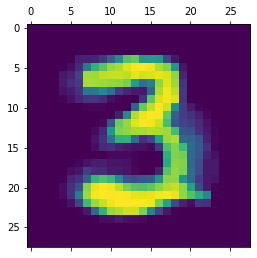

In [724]:
plt.matshow(np.reshape(G[150],(28,28)))

In [539]:
E

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 8., 8., 8., 8., 8., 8., 8.,
       8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.])

In [268]:
B=pooling([28,28],4,4)
B.pl_index()
B.to_pooling(train_data[:200,1:])[1]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  10., 253.,
       253., 253.,   0.,   0.,   0., 253., 253., 253., 255.,   0.,   0.,
       246., 253.,  28.,   0., 255.,   0.,   0., 253., 230., 114., 253.,
       253.,   0.,   0., 252., 253., 253., 223.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [485]:
A = train_data[2:100]
B = train_data[20:30]
np.concatenate((B,A),axis=0)

array([[4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.],
       ...,
       [8., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [228]:
M = UOM(J[:1000],J[1000:,],10,0.1)
H = M.loop_train(10,r_mode='treshold',treshold=0.3)

In [216]:
H = np.reshape(G[1],(5,5))
K = np.reshape(train_data[1:3,1:],(2,28,28))

In [249]:
B = convolution([28,28],2,padding=False)
np.shape(B.cv_index())    

(576, 25, 1)

In [217]:
from scipy import signal
X = signal.convolve2d(K,H,boundary='fill', mode='same')
np.shape(X)

ValueError: convolve2d inputs must both be 2D arrays

array([ 222688.,  743535., 1724450., 1221382., 2489577., 1336649.,
       2321214.])

In [320]:
A = train_data[2:9,1:400]

C = train_data[8,1:400]

np.dot(C,A.T)

array([   2002.,  273809.,  430630.,  581317., 1213666.,  602178.,
       1074593.])

In [321]:
A = train_data[2:9,400:784]

C = train_data[8,400:784]

np.dot(C,A.T)

array([ 220686.,  469726., 1293820.,  640065., 1275911.,  734471.,
       1246621.])